In [2]:
import os
from datetime import datetime
import pytz
import csv
import cv2
import pandas as pd
from ultralytics import YOLO
from dateutil import parser
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil
import logging


In [3]:

def extract_datetime_from_filename(filename):
    """Extracts the timestamp from the image filename."""
    name, _ = os.path.splitext(filename)
    date_part = name.split('_')[-1]
    try:
        timestamp = datetime.strptime(date_part, "%Y%m%d%H%M%S")
        utc_timezone = pytz.utc
        timestamp_utc = utc_timezone.localize(timestamp)
        est_timezone = pytz.timezone('America/New_York')
        timestamp_est = timestamp_utc.astimezone(est_timezone)
        return timestamp_est
    except ValueError as e:
        print(f"Error parsing date from filename {filename}: {e}")
        return None


def parse_csv(file_path):
    """Parses a CSV with event numbers, start, and end times to create a list of events."""
    events = []
    with open(file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            event_id = int(row['flood_event'])
            start_time = parser.parse(row['start_time_EST'])
            end_time = parser.parse(row['end_time_EST'])
            est = pytz.timezone('America/New_York')
            if start_time.tzinfo is None:
                start_time = est.localize(start_time, is_dst=False)
            if end_time.tzinfo is None:
                end_time = est.localize(end_time, is_dst=False)
            events.append({
                'event_id': event_id,
                'start_time': start_time,
                'end_time': end_time
            })
    return events


def process_folder(folder_path, events):
    """Sorts images into events based on their timestamps extracted from filenames."""
    files = os.listdir(folder_path)
    timestamps_dict = {}
    
    for file in files:
        timestamp = extract_datetime_from_filename(file)
        if timestamp:
            timestamps_dict[file] = timestamp
        else:
            print(f"Failed to extract datetime from filename: {file}")
    
    event_images = {event['event_id']: [] for event in events}
    event_images[1000] = []  # For images outside any event

    for file, timestamp in timestamps_dict.items():
        assigned = False
        for event in events:
            if event['start_time'] <= timestamp <= event['end_time']:
                event_images[event['event_id']].append(file)
                assigned = True
                break
        if not assigned:
            event_images[1000].append(file)
    
    return event_images


def copy_and_rename_files_with_event_numbers(folder_path, event_images, new_folder_path):
    """Copies and renames files by appending the event number to the filenames."""
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)
    
    for event_id, files in event_images.items():
        for file in files:
            old_file_path = os.path.join(folder_path, file)
            new_file_name = f"{os.path.splitext(file)[0]}_event{event_id}{os.path.splitext(file)[1]}"
            new_file_path = os.path.join(new_folder_path, new_file_name)
            shutil.copy2(old_file_path, new_file_path)


def count_objects_in_folder(folder_path):
    """Counts objects in all images within a folder and returns the counts per image."""
    
    # Disable YOLO internal logging
    logging.getLogger('ultralytics').setLevel(logging.CRITICAL)
    model = YOLO("yolov8x.pt", verbose=False)  # Suppress verbose logging# Load the model with verbose=False to suppress internal progress bars
    
    # Classes to look for (based on COCO dataset class IDs)
    CLASS_IDS = {
        'car': 2,
        'truck': 7,
        'motorcycle': 3,
        'bicycle': 1,
        'person': 0
    }

    # Dictionary to store counts for each image
    folder_counts = {}

    # Get the list of image files in the folder
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Progress bar for processing images (enabled)
    with tqdm(total=len(files), desc="Processing Images", disable=False) as pbar:
        # Loop through all image files in the folder
        for filename in files:
            image_path = os.path.join(folder_path, filename)

            # Load the image
            image = cv2.imread(image_path)

            # Check if the image was loaded correctly
            if image is None:
                pbar.update(1)  # Update the progress bar even if there's an error
                continue
            
            # Convert the image to RGB (YOLO models typically expect RGB images)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Perform inference
            results = model(image_rgb)

            # Check if results are a list and access the first result
            if isinstance(results, list) and len(results) > 0:
                results = results[0]  # Get the first result

            # Initialize counters for each class
            counts = {key: 0 for key in CLASS_IDS.keys()}

            # Check if detections exist and iterate over them
            if hasattr(results, 'boxes') and results.boxes is not None:
                for box in results.boxes:
                    class_id = int(box.cls)  # Get class ID of detected object
                    for key, value in CLASS_IDS.items():
                        if class_id == value:
                            counts[key] += 1
            else:
                print(f"Warning: No detections for {image_path}")

            # Store the counts for this image
            folder_counts[filename] = counts

            # Update the progress bar after each image is processed
            pbar.update(1)

    return folder_counts


def object_counts_to_csv(image_directory):
    """Saves object counts for each image and its event number into a CSV."""
    folder_counts = count_objects_in_folder(image_directory)
    results_list = []
    
    for filename, counts in folder_counts.items():
        event_number = filename.split('_event')[-1].split('.')[0] if '_event' in filename else "unknown"
        counts['image'] = filename
        counts['event_number'] = event_number
        results_list.append(counts)

    df = pd.DataFrame(results_list)
    df.to_csv("object_counts.csv", index=False)


def plot_from_df(csv_to_be_plotted):
    """Plots object counts per event from a CSV file."""
    object_df = pd.read_csv(csv_to_be_plotted)
    summed_df = object_df.groupby('event_number').sum()
    summed_df['Total Objects'] = (summed_df['car'] + summed_df['truck'] + 
                                  summed_df['motorcycle'] + summed_df['bicycle'] + summed_df['person'])
    summed_df = summed_df.reset_index()
    summed_df = summed_df[summed_df['event_number'] != '1000']
    
    x_values = range(len(summed_df))
    plt.figure(figsize=(12, 6))
    plt.scatter(x_values, summed_df['Total Objects'], color='coral', marker='o')
    plt.xlabel('Event Number')
    plt.xticks(x_values, summed_df['event_number'])
    plt.ylabel('Total Objects')
    plt.title('Total Objects by Event Number')
    plt.grid(True)
    plt.show()



Processing Images: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


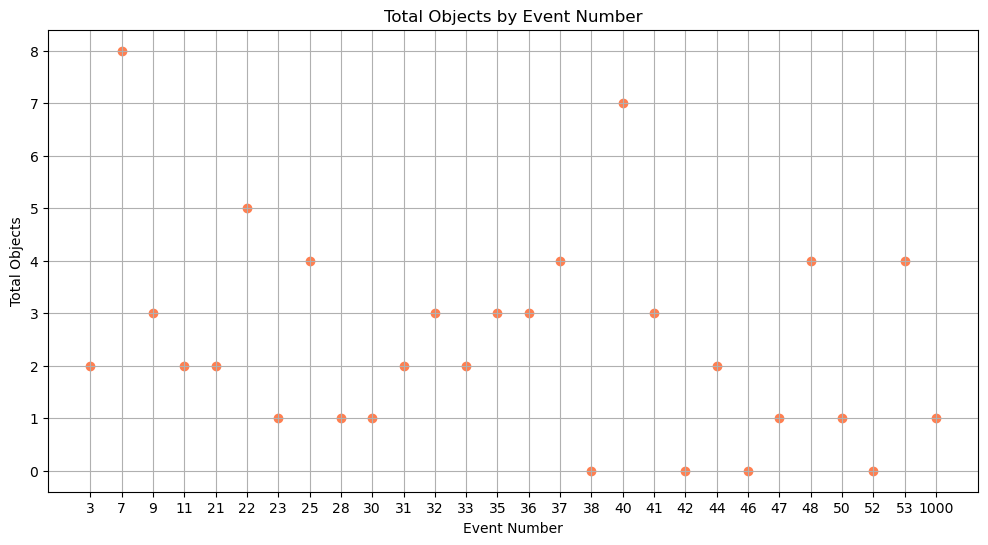

In [5]:
# Necessary Variables here: 

# Set folder path with folder location containing images to be processed (subjected to object counting)
folder_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal_Hazards_Lab_Stuff\Research_Project_Items_and_Python\SDF\Water_Quality_Images\Scripts\Sample Images"

# Set file path to file containing flood event numbers, start and end times
csv_file_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal_Hazards_Lab_Stuff\Research_Project_Items_and_Python\SDF\Water_Quality_Images\Scripts\abbr_flood_events.csv"

# Set new file path for folder containing updated file names (with event number appended)
new_folder_path = os.path.join(folder_path, "Updated_Files")  # New folder path

# Parse events from CSV
events = parse_csv(csv_file_path)

# Process folder and sort images into events
event_images = process_folder(folder_path, events)

images_for_yoloing = copy_and_rename_files_with_event_numbers(folder_path, event_images, new_folder_path)


# Set folder path for images to be counted (add updated file )
yolo_folder_path = os.path.join(folder_path, "Updated_Files")

# Name of CSV to be plotted
csv_to_be_plotted = "object_counts.csv"

object_counts_to_csv(yolo_folder_path)

plot_from_df(csv_to_be_plotted)